In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from black import Encoding



warnings.filterwarnings("ignore")

sns.set(style="darkgrid", font_scale=1.5)

pd.set_option("display.max.columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: '%.3f' % x)
pd.set_option('display.width', 1000000)


from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, f1_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer

In [ ]:
# Projenin amacı : 4 rüzgar türbine ait scada verilerini kullanrak rüzgar türbinin üreticeği aktif gücü zaman serisi modelleri kullanarak tahmin etme

In [ ]:
####################################################################################
# 2- Veri setini yükleme
####################################################################################

data_2017 = pd.read_excel("/Users/gulsah/Desktop/wind_turbines/Wind-Turbine-SCADA-signals-2017_0.xlsx")
data_2016 = pd.read_excel("/Users/gulsah/Desktop/vs code/wind_turbines/adsız klasör/Wind-Turbine-SCADA-signals-2016.xlsx")

df = pd.concat([data_2016, data_2017], axis=0)
df.head(10)

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Amb_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_ActPwrGen2,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_ReactPwrGen2,Prod_LatestAvg_TotReactPwr,HVTrafo_Phase1_Temp_Avg,HVTrafo_Phase2_Temp_Avg,HVTrafo_Phase3_Temp_Avg,Grd_InverterPhase1_Temp_Avg,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Gen_SlipRing_Temp_Avg,Spin_Temp_Avg,Blds_PitchAngle_Min,Blds_PitchAngle_Max,Blds_PitchAngle_Avg,Blds_PitchAngle_Std,Cont_VCP_ChokcoilTemp_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Cont_VCP_WtrTemp_Avg,Grd_Prod_Pwr_Avg,Grd_Prod_CosPhi_Avg,Grd_Prod_Freq_Avg,Grd_Prod_VoltPhse1_Avg,Grd_Prod_VoltPhse2_Avg,Grd_Prod_VoltPhse3_Avg,Grd_Prod_CurPhse1_Avg,Grd_Prod_CurPhse2_Avg,Grd_Prod_CurPhse3_Avg,Grd_Prod_Pwr_Max,Grd_Prod_Pwr_Min,Grd_Busbar_Temp_Avg,Rtr_RPM_Std,Amb_WindSpeed_Est_Avg,Grd_Prod_Pwr_Std,Grd_Prod_ReactPwr_Avg,Grd_Prod_ReactPwr_Max,Grd_Prod_ReactPwr_Min,Grd_Prod_ReactPwr_Std,Grd_Prod_PsblePwr_Avg,Grd_Prod_PsblePwr_Max,Grd_Prod_PsblePwr_Min,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
0,T06,2016-01-08T23:10:00+00:00,1634.300,1226.900,1416.400,96.400,49.000,62,63,64,30,52,57,31,14.500,10.800,12.500,11.300,2.800,6.500,1.100,-9.400,197.600,18,0,82204.000,0,82204.000,0,-24066,0,-24066,55,59,56,39,41,27,41,27,19,-2.400,-0.900,-1.900,0.400,104,40,40,38,38,491.900,1.000,49.900,399.500,397.600,397.600,417.900,445.900,423.200,796.100,141.300,41,0.800,6.600,132.400,-144.400,-131.900,-162.200,6.100,490.900,810.400,132.500,133.000,-998.700,-649.200,-1000.000,18.500,998.700,1000.000,649.200,18.500,40,207.100
1,T06,2016-04-19T12:20:00+00:00,1796.100,1597.000,1680.000,29.800,66.000,97,107,111,43,54,62,34,15.800,14.200,14.900,21.900,2.900,12.100,2.500,7.500,137.400,17,0,331405.000,0,331405.000,0,-36814,0,-36814,79,86,85,46,43,27,41,38,21,-1.500,11.900,4.300,3.200,125,48,48,46,42,1988.100,1.000,50.000,399.200,397.100,398.200,1667.800,1693.300,1658.100,2103.300,1665.800,47,0.200,12.200,54.700,-220.900,-215.600,-225.400,2.100,1982.300,2000.000,1622.400,52.700,-615.200,-583.300,-1000.000,91.900,423.800,783.500,406.100,52.700,57,129.900
2,T01,2016-01-08T23:10:00+00:00,1657.500,1299.200,1495.000,83.800,47.000,62,62,61,29,49,54,26,14.700,11.500,13.200,13.400,1.300,7.100,1.200,-19.300,201.200,18,0,98177.000,0,98177.000,0,-24113,0,-24113,70,79,68,39,40,27,43,27,19,-2.400,-1.200,-2.000,0.300,98,39,39,38,38,588.200,1.000,49.900,400.400,398.500,398.800,489.200,521.600,498.600,1054.100,298.000,39,0.700,7.000,144.400,-144.400,-131.300,-162.100,6.100,588.100,1075.100,275.000,145.000,-1000.000,-1000.000,-1000.000,0.000,1000.000,1000.000,1000.000,0.000,49,220.600
3,T11,2016-04-19T12:30:00+00:00,1771.200,1590.000,1677.500,29.400,66.000,111,110,110,50,59,68,31,15.700,14.100,14.900,25.000,2.100,11.800,2.400,-1.300,122.200,17,0,326317.000,0,326317.000,0,-36349,0,-36349,81,97,87,49,46,28,47,40,21,-2.400,12.000,3.600,3.300,116,49,51,50,44,1958.200,1.000,50.000,399.200,396.200,398.200,1633.400,1669.700,1642.700,2106.700,1220.000,48,0.200,12.000,136.100,-218.100,-212.300,-222.600,2.400,1951.600,2000.000,1142.900,136.000,-639.600,-583.300,-1000.000,132.400,452.200,1000.000,406.100,125.100,56,123.500
4,T07,2016-01-08T23:50:00+00:00,1667.500,1277.400,1481.300,119.100,46.000,73,72,71,30,57,60,27,14.800,11.300,13.100,18.100,0.700,7.200,1.700,15.600,221.700,18,0,114924.000,0,114924.000,0,-26293,0,-26293,78,82,82

In [ ]:
####################################################################################
# 3-Veriye genel bir bakış
####################################################################################

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Duplicated Values #####################")
    print(dataframe.duplicated().sum())
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Number of Unique Values #####################")
    print(dataframe.nunique())

check_df(df)

##################### Shape #####################
(417141, 83)
##################### Types #####################
Turbine_ID                      object
Timestamp                       object
Gen_RPM_Max                    float64
Gen_RPM_Min                    float64
Gen_RPM_Avg                    float64
Gen_RPM_Std                    float64
Gen_Bear_Temp_Avg              float64
Gen_Phase1_Temp_Avg              int64
Gen_Phase2_Temp_Avg              int64
Gen_Phase3_Temp_Avg              int64
Hyd_Oil_Temp_Avg                 int64
Gear_Oil_Temp_Avg                int64
Gear_Bear_Temp_Avg               int64
Nac_Temp_Avg                     int64
Rtr_RPM_Max                    float64
Rtr_RPM_Min                    float64
Rtr_RPM_Avg                    float64
Amb_WindSpeed_Max              float64
Amb_WindSpeed_Min              float64
Amb_WindSpeed_Avg              float64
Amb_WindSpeed_Std              float64
Amb_WindDir_Relative_Avg       float64
Amb_WindDir_Abs_Avg          

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417141 entries, 0 to 209235
Data columns (total 83 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Turbine_ID                   417141 non-null  object 
 1   Timestamp                    417141 non-null  object 
 2   Gen_RPM_Max                  417141 non-null  float64
 3   Gen_RPM_Min                  417141 non-null  float64
 4   Gen_RPM_Avg                  417141 non-null  float64
 5   Gen_RPM_Std                  417141 non-null  float64
 6   Gen_Bear_Temp_Avg            417137 non-null  float64
 7   Gen_Phase1_Temp_Avg          417141 non-null  int64  
 8   Gen_Phase2_Temp_Avg          417141 non-null  int64  
 9   Gen_Phase3_Temp_Avg          417141 non-null  int64  
 10  Hyd_Oil_Temp_Avg             417141 non-null  int64  
 11  Gear_Oil_Temp_Avg            417141 non-null  int64  
 12  Gear_Bear_Temp_Avg           417141 non-null  int64  
 13  Nac_

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gen_RPM_Max,417141.000,1190.486,631.827,0.000,315.200,1417.700,1683.800,2040.900
Gen_RPM_Min,417141.000,936.671,607.263,0.000,194.800,1231.100,1359.600,1675.600
Gen_RPM_Avg,417141.000,1067.096,608.989,0.000,276.200,1274.600,1590.300,1685.000
Gen_RPM_Std,417141.000,67.925,110.785,0.000,13.300,27.800,71.200,823.100
Gen_Bear_Temp_Avg,417137.000,46.116,15.496,18.000,35.000,44.000,55.000,205.000
Gen_Phase1_Temp_Avg,417141.000,64.033,27.460,19.000,43.000,60.000,76.000,205.000
Gen_Phase2_Temp_Avg,417141.000,64.076,26.807,19.000,43.000,61.000,76.000,205.000
Gen_Phase3_Temp_Avg,417141.000,63.392,26.083,19.000,43.000,60.000,76.000,205.000
Hyd_Oil_Temp_Avg,417141.000,35.423,7.523,20.000,29.000,34.000,41.000,55.000
Gear_Oil_Temp_Avg,417141.000,47.954,6.581,24.000,43.000,49.000,53.000,65.000


In [ ]:
df.describe(include="object")

,Turbine_ID,Timestamp
count,417141,417141
unique,4,104909
top,T11,2016-10-30T02:40:00+00:00
freq,104798,8


In [ ]:
#####Veri Hakkında genel bilgiler####
# Veride 417141 gözlem 83 değişken vardır.
# Veride ki değişkelerin 81 tanesi sayısal 2 tanesi kategorik görünmemektedir.
# 4 adet türbin verisi bulunmaktadır (T07, T06, T01, T11)
#Gen_Bear_Temp_Avg değişkeninde 4, Grd_Prod_CosPhi_Avg değişkeninde 4 olmak üzere toplamda 8 eksik gözlem vardır
####################################################################################

In [ ]:
####################################################################################
# 4- Veri Ön İşleme
####################################################################################

# 1- Eksik değerler
# eksik değerleri incelediğimizde toplamda 8 tane olduğunu görmüştük. eksik değerlerin sayısının az olması sebebiyle siliyoruz

#Eksik değerlerin hangi satırlarda olduğunu kontrol ediyoruz
df[df.isnull().any(axis=1)]

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Amb_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_ActPwrGen2,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_ReactPwrGen2,Prod_LatestAvg_TotReactPwr,HVTrafo_Phase1_Temp_Avg,HVTrafo_Phase2_Temp_Avg,HVTrafo_Phase3_Temp_Avg,Grd_InverterPhase1_Temp_Avg,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Gen_SlipRing_Temp_Avg,Spin_Temp_Avg,Blds_PitchAngle_Min,Blds_PitchAngle_Max,Blds_PitchAngle_Avg,Blds_PitchAngle_Std,Cont_VCP_ChokcoilTemp_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Cont_VCP_WtrTemp_Avg,Grd_Prod_Pwr_Avg,Grd_Prod_CosPhi_Avg,Grd_Prod_Freq_Avg,Grd_Prod_VoltPhse1_Avg,Grd_Prod_VoltPhse2_Avg,Grd_Prod_VoltPhse3_Avg,Grd_Prod_CurPhse1_Avg,Grd_Prod_CurPhse2_Avg,Grd_Prod_CurPhse3_Avg,Grd_Prod_Pwr_Max,Grd_Prod_Pwr_Min,Grd_Busbar_Temp_Avg,Rtr_RPM_Std,Amb_WindSpeed_Est_Avg,Grd_Prod_Pwr_Std,Grd_Prod_ReactPwr_Avg,Grd_Prod_ReactPwr_Max,Grd_Prod_ReactPwr_Min,Grd_Prod_ReactPwr_Std,Grd_Prod_PsblePwr_Avg,Grd_Prod_PsblePwr_Max,Grd_Prod_PsblePwr_Min,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
96752,T06,2017-08-17T11:30:00+00:00,1315.300,1226.900,1251.600,12.400,NaN,63,65,65,38,47,52,37,11.600,10.900,11.100,7.500,0.800,4.300,0.800,12.000,110.100,29,-187,17332.000,0,17146.000,-205,-10478,0,-10682,52,55,52,38,44,39,43,36,34,-1.800,4.800,-0.200,1.200,99,39,37,37,37,102.700,NaN,50.000,399.100,397.400,397.100,215.500,224.300,219.500,252.300,-31.200,42,0.100,4.300,69.700,-64.200,649.000,-760.000,286.100,107.500,259.200,0.000,62.800,-509.000,0.000,-1000.000,317.900,509.000,1000.000,0.000,317.900,46,98.000
127575,T01,2017-08-17T15:30:00+00:00,1694.600,1219.700,1595.600,119.100,NaN,82,81,79,39,56,62,40,15.000,10.800,14.100,17.800,1.000,8.600,2.200,8.300,119.900,33,0,165420.000,0,165420.000,0,-30208,0,-30208,82,86,81,45,47,41,50,43,35,-2.400,0.600,-1.700,0.600,86,46,45,45,44,993.800,NaN,50.000,399.700,398.700,400.800,835.000,857.900,838.200,1643.600,39.600,46,1.100,8.200,384.400,-181.200,-171.700,-188.000,3.300,994.100,1659.500,38.700,382.600,-965.300,-189.600,-1000.000,135.900,958.500,1000.000,189.600,137.600,62,111.600
127945,T11,2017-08-17T12:20:00+00:00,1590.800,0.000,1010.500,611.700,NaN,53,54,54,41,51,58,36,14.100,0.000,8.900,11.300,1.600,6.500,1.400,21.500,148.600,30,-657,44842.000,0,44185.000,-1088,-19047,0,-20135,54,59,54,42,44,40,45,35,34,-2.400,86.200,22.300,36.800,64,41,42,42,42,263.800,NaN,50.000,396.400,394.200,394.900,249.300,265.500,251.200,839.300,-30.500,42,5.500,6.400,233.300,-120.500,-9.800,-238.300,69.700,461.100,1152.900,105.900,200.000,-665.900,0.000,-1000.000,457.600,665.900,1000.000,0.000,457.600,44,127.000
139530,T07,2017-08-17T11:30:00+00:00,1370.200,1223.300,1257.900,21.900,NaN,67,67,67,43,49,52,35,12.100,10.800,11.100,8.100,1.900,4.700,0.900,-28.600,64.300,29,0,22771.000,0,22771.000,0,-18275,0,-18275,61,68,65,39,42,41,44,36,36,-2.300,0.800,-0.800,0.600,92,39,39,41,39,137.300,NaN,50.000,398.500,397.100,396.700,274.100,286.600,279.300,280.100,17.200,41,0.200,4.700,60.200,-108.600,663.800,-928.700,326.600,137.800,311.200,17.000,60.400,-651.500,-83.300,-1000.000,257.200,651.500,1000.000,83.300,257.200,54,92.900


In [ ]:
#eksik değerleri temizleme
df=df.dropna()

In [ ]:
#eksik değer kontrolü
df.isnull().sum().sum()

0

In [ ]:
df.shape #verinin boyutu 417137 satır 83 sütun olmuştur

(417137, 83)

In [ ]:
#rastgele 5 satıra bakalım
df.sample(5)

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Amb_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_ActPwrGen2,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_ReactPwrGen2,Prod_LatestAvg_TotReactPwr,HVTrafo_Phase1_Temp_Avg,HVTrafo_Phase2_Temp_Avg,HVTrafo_Phase3_Temp_Avg,Grd_InverterPhase1_Temp_Avg,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Gen_SlipRing_Temp_Avg,Spin_Temp_Avg,Blds_PitchAngle_Min,Blds_PitchAngle_Max,Blds_PitchAngle_Avg,Blds_PitchAngle_Std,Cont_VCP_ChokcoilTemp_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Cont_VCP_WtrTemp_Avg,Grd_Prod_Pwr_Avg,Grd_Prod_CosPhi_Avg,Grd_Prod_Freq_Avg,Grd_Prod_VoltPhse1_Avg,Grd_Prod_VoltPhse2_Avg,Grd_Prod_VoltPhse3_Avg,Grd_Prod_CurPhse1_Avg,Grd_Prod_CurPhse2_Avg,Grd_Prod_CurPhse3_Avg,Grd_Prod_Pwr_Max,Grd_Prod_Pwr_Min,Grd_Busbar_Temp_Avg,Rtr_RPM_Std,Amb_WindSpeed_Est_Avg,Grd_Prod_Pwr_Std,Grd_Prod_ReactPwr_Avg,Grd_Prod_ReactPwr_Max,Grd_Prod_ReactPwr_Min,Grd_Prod_ReactPwr_Std,Grd_Prod_PsblePwr_Avg,Grd_Prod_PsblePwr_Max,Grd_Prod_PsblePwr_Min,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
83133,T07,2016-09-19T22:30:00+00:00,1267.900,1238.700,1250.000,5.100,34.000,43,43,42,42,44,47,30,11.200,11.000,11.100,7.300,2.400,4.500,0.600,-4.200,139.500,22,0,15523.000,0,15523.000,0,-9264,0,-9264,55,64,81,39,38,31,37,29,26,-1.400,0.000,-0.700,0.300,54,40,40,41,39,92.700,0.400,50.000,398.300,396.300,394.500,203.900,221.700,214.800,205.500,14.500,35,0.000,4.300,42.900,-56.600,386.300,-762.000,250.100,92.400,207.400,13.700,43.000,-452.700,-67.000,-1000.000,210.400,452.700,1000.000,67.000,210.400,35,143.700
64272,T07,2017-11-10T18:20:00+00:00,1727.000,1637.700,1681.300,11.700,47.000,88,87,83,35,58,62,27,15.200,14.600,14.900,16.400,3.300,10.500,1.600,0.800,21.100,19,0,317460.000,0,317460.000,0,-34149,0,-34149,85,88,86,45,33,28,42,32,20,-2.300,3.400,-0.400,1.500,104,47,47,48,41,1904.500,1.000,50.000,399.400,397.700,398.600,1592.500,1604.200,1588.800,2090.500,1524.900,43,0.100,10.800,126.900,-205.000,-195.400,-211.100,4.200,1898.100,2000.000,1500.400,124.000,-741.500,-583.300,-1000.000,167.200,507.900,905.500,406.100,123.900,45,20.300
81377,T06,2016-02-19T23:00:00+00:00,1682.100,1559.900,1655.000,19.700,44.000,59,63,65,29,55,60,25,14.900,13.800,14.700,13.900,4.400,8.900,1.200,6.800,88.700,14,0,211092.000,0,211092.000,0,-28195,0,-28195,67,72,68,35,38,22,38,28,15,-2.500,-1.000,-2.100,0.300,105,37,37,35,32,1264.600,1.000,50.000,397.700,395.800,395.500,1055.900,1089.900,1071.100,1648.300,842.300,40,0.200,9.000,196.800,-169.200,-161.800,-177.400,3.600,1262.500,1660.500,822.100,197.400,-1000.000,-1000.000,-1000.000,0.000,973.100,1000.000,745.400,47.000,39,81.900
159533,T07,2016-05-06T01:00:00+00:00,1277.500,1238.800,1254.400,6.500,39.000,58,58,58,48,46,50,27,11.300,11.000,11.100,7.500,1.300,4.800,0.700,6.900,148.100,18,0,30802.000,0,30802.000,0,-15601,0,-15601,58,67,78,39,38,27,38,28,19,-1.600,1.600,-0.900,0.200,93,39,39,41,39,185.100,0.900,50.000,398.900,396.800,396.100,165.300,192.200,164.400,267.200,130.900,36,0.100,5.000,23.300,-93.400,-33.700,-141.000,15.100,185.200,268.800,130.100,23.200,-892.200,-636.600,-1000.000,86.000,892.200,1000.000,636.600,86.000,39,141.200
86559,T11,2016-10-25T18:10:00+00:00,1620.400,1246.200,1456.500,99.900,57.000,64,65,65,35,52,59,31,14.400,11.000,12.900,14.300,2.200,6.800,1.100,5.100,90.700,26,0,89778.000,0,89778.000,0,-18149,0,-18149,52,57,53,40,42,33,44,35,27

In [ ]:
# Değişken tiplerini gruplandırma
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)
print("#############")
print(f"Cat_Cols : {cat_cols}")
print("#############")
print(f"Num_Cols : {num_cols}")
print("#############")
print(f"Cat_But_Car : {cat_but_car}")

Observations: 417137
Variables: 83
cat_cols: 5
num_cols: 77
cat_but_car: 1
num_but_cat: 4
#############
Cat_Cols : ['Turbine_ID', 'Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2', 'Grd_Prod_CosPhi_Avg', 'Grd_Prod_Freq_Avg']
#############
Num_Cols : ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1', 'Prod_LatestAvg_TotReactPwr', 'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg', 'Con

In [ ]:
df['Prod_LatestAvg_ActPwrGen2'].nunique()
df["Prod_LatestAvg_ReactPwrGen2"].nunique()

1

In [ ]:
#İki değişkenin yalnızca 1 değeri olduğu için bu değişkenleri siliyoruz
df = df.drop(['Prod_LatestAvg_ActPwrGen2',"Prod_LatestAvg_ReactPwrGen2"], axis=1)
df.shape  # (417137, 81)

(417137, 81)

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print("#############")
print(f"Cat_Cols : {cat_cols}")
print("#############")
print(f"Num_Cols : {num_cols}")
print("#############")
print(f"Cat_But_Car : {cat_but_car}")

Observations: 417137
Variables: 81
cat_cols: 3
num_cols: 77
cat_but_car: 1
num_but_cat: 2
#############
Cat_Cols : ['Turbine_ID', 'Grd_Prod_CosPhi_Avg', 'Grd_Prod_Freq_Avg']
#############
Num_Cols : ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1', 'Prod_LatestAvg_TotReactPwr', 'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg

In [ ]:
## 2- Aykırı değerler

def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1) #Q1 value calculation
    quartile3 = dataframe[col_name].quantile(q3) #Q3 value calculation
    interquartile_range = quartile3 - quartile1 #IQR calculation
    up_limit = quartile3 + 1.5 * interquartile_range #determination of the upper limit
    low_limit = quartile1 - 1.5 * interquartile_range #determination of the lower limit
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)  # Alt ve üst limitlerin belirlenmesi

    ## Gözlem sayısı 10'dan büyükse ilk 5 gözlemi alın
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    # Eğer değilse hepsini getir
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index



def count_outliers(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]
    return outliers.shape[0]

for col in num_cols:
    print(col, count_outliers(df, col))

Gen_RPM_Max 0
Gen_RPM_Min 0
Gen_RPM_Avg 0
Gen_RPM_Std 0
Gen_Bear_Temp_Avg 103
Gen_Phase1_Temp_Avg 0
Gen_Phase2_Temp_Avg 0
Gen_Phase3_Temp_Avg 0
Hyd_Oil_Temp_Avg 0
Gear_Oil_Temp_Avg 0
Gear_Bear_Temp_Avg 0
Nac_Temp_Avg 0
Rtr_RPM_Max 0
Rtr_RPM_Min 0
Rtr_RPM_Avg 0
Amb_WindSpeed_Max 0
Amb_WindSpeed_Min 1
Amb_WindSpeed_Avg 0
Amb_WindSpeed_Std 34
Amb_WindDir_Relative_Avg 0
Amb_WindDir_Abs_Avg 0
Amb_Temp_Avg 0
Prod_LatestAvg_ActPwrGen0 0
Prod_LatestAvg_ActPwrGen1 0
Prod_LatestAvg_TotActPwr 0
Prod_LatestAvg_ReactPwrGen0 0
Prod_LatestAvg_ReactPwrGen1 68
Prod_LatestAvg_TotReactPwr 74
HVTrafo_Phase1_Temp_Avg 0
HVTrafo_Phase2_Temp_Avg 0
HVTrafo_Phase3_Temp_Avg 0
Grd_InverterPhase1_Temp_Avg 0
Cont_Top_Temp_Avg 0
Cont_Hub_Temp_Avg 0
Cont_VCP_Temp_Avg 0
Gen_SlipRing_Temp_Avg 24
Spin_Temp_Avg 0
Blds_PitchAngle_Min 0
Blds_PitchAngle_Max 0
Blds_PitchAngle_Avg 0
Blds_PitchAngle_Std 10
Cont_VCP_ChokcoilTemp_Avg 0
Grd_RtrInvPhase1_Temp_Avg 1
Grd_RtrInvPhase2_Temp_Avg 0
Grd_RtrInvPhase3_Temp_Avg 2
Cont_VCP_W

In [ ]:
# Aykırı değeri olan sütunları ve aykırı değer sayılarını saklayan sözlük
outlier_counts = {col: count_outliers(df, col) for col in num_cols if col in df.columns and check_outlier(df, col)}
outlier_counts

{'Gen_Bear_Temp_Avg': 103,
 'Amb_WindSpeed_Min': 1,
 'Amb_WindSpeed_Std': 34,
 'Prod_LatestAvg_ReactPwrGen1': 68,
 'Prod_LatestAvg_TotReactPwr': 74,
 'Gen_SlipRing_Temp_Avg': 24,
 'Blds_PitchAngle_Std': 10,
 'Grd_RtrInvPhase1_Temp_Avg': 1,
 'Grd_RtrInvPhase3_Temp_Avg': 2,
 'Grd_Prod_VoltPhse1_Avg': 27,
 'Grd_Prod_VoltPhse2_Avg': 23,
 'Grd_Prod_VoltPhse3_Avg': 3,
 'Grd_Prod_ReactPwr_Avg': 73,
 'Gen_Bear2_Temp_Avg': 119}

In [ ]:
# Sözlüğü aykırı değer sayılarına göre azalan sırada sıralayın
sorted_outlier_counts = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)

In [ ]:
#aykırı değer olan değişkenler
outlier_columns = [col for col in num_cols if check_outlier(df, col)]

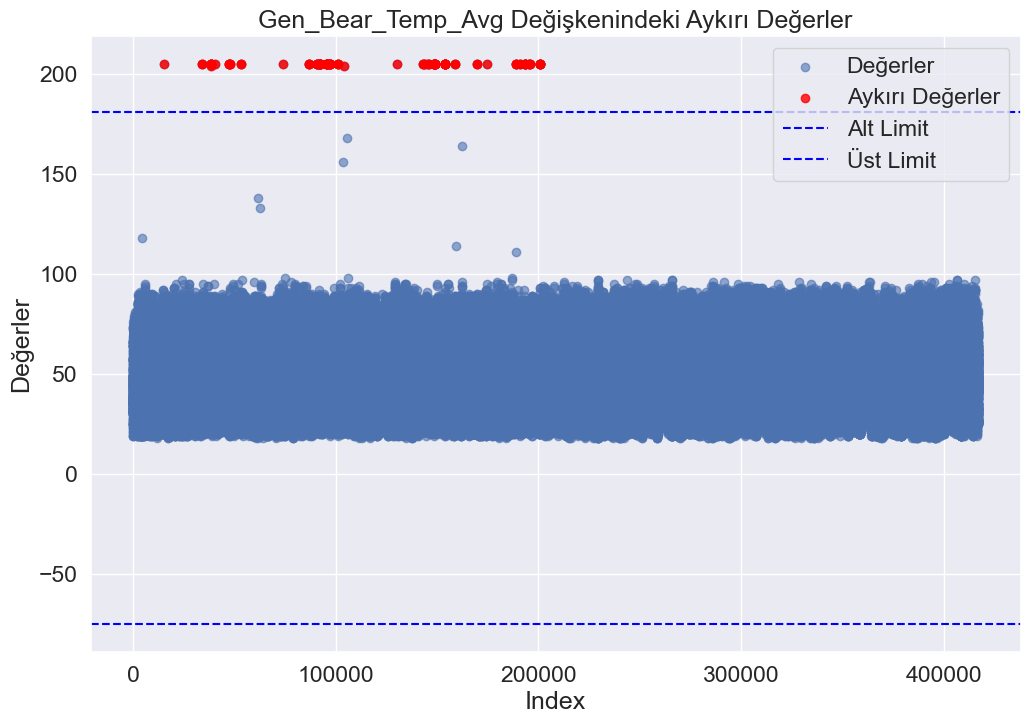

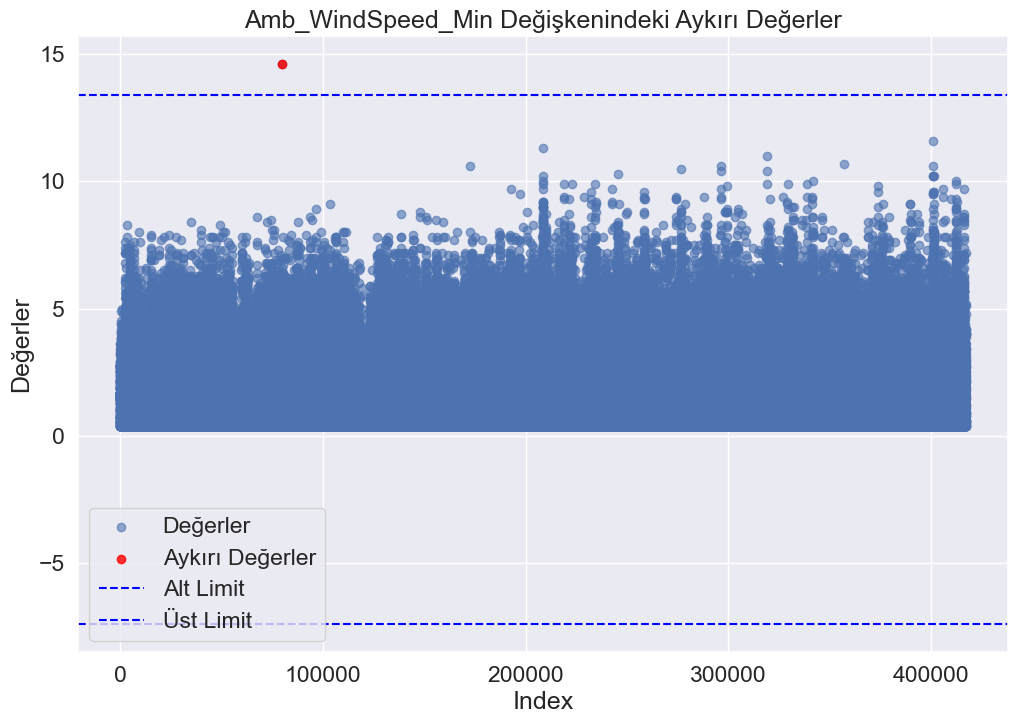

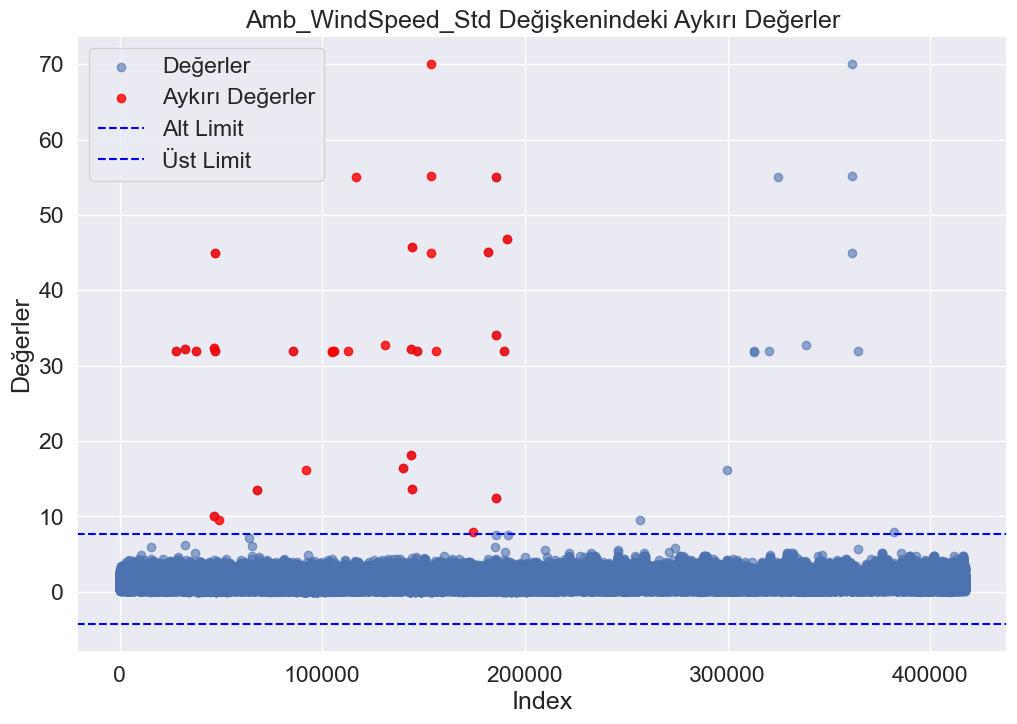

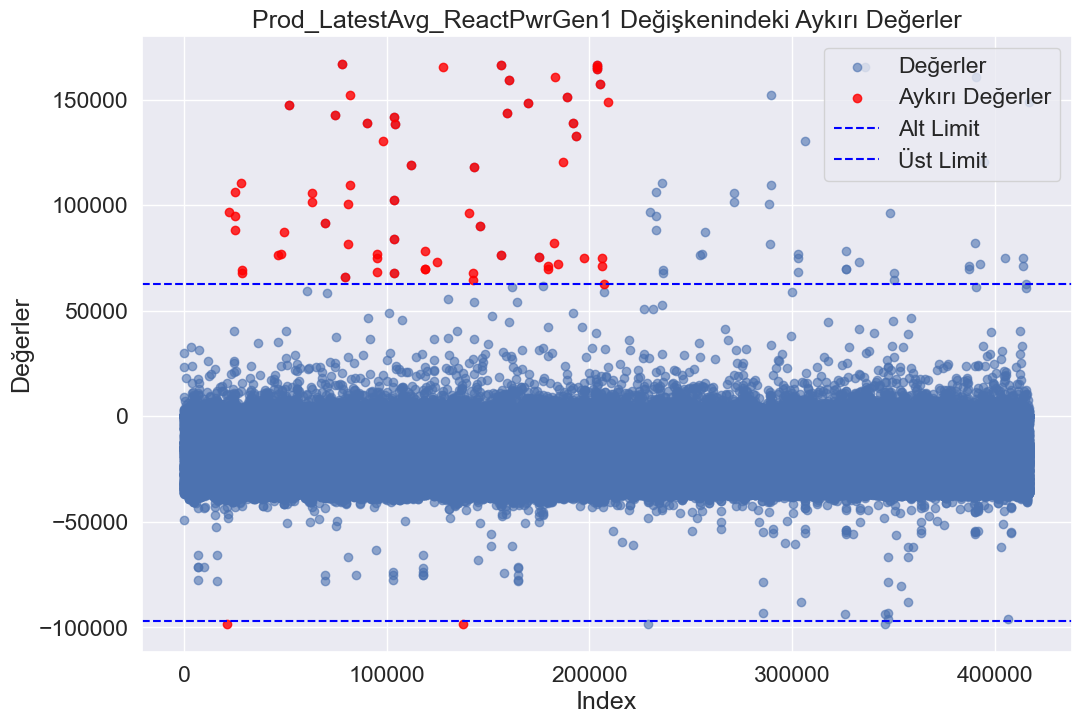

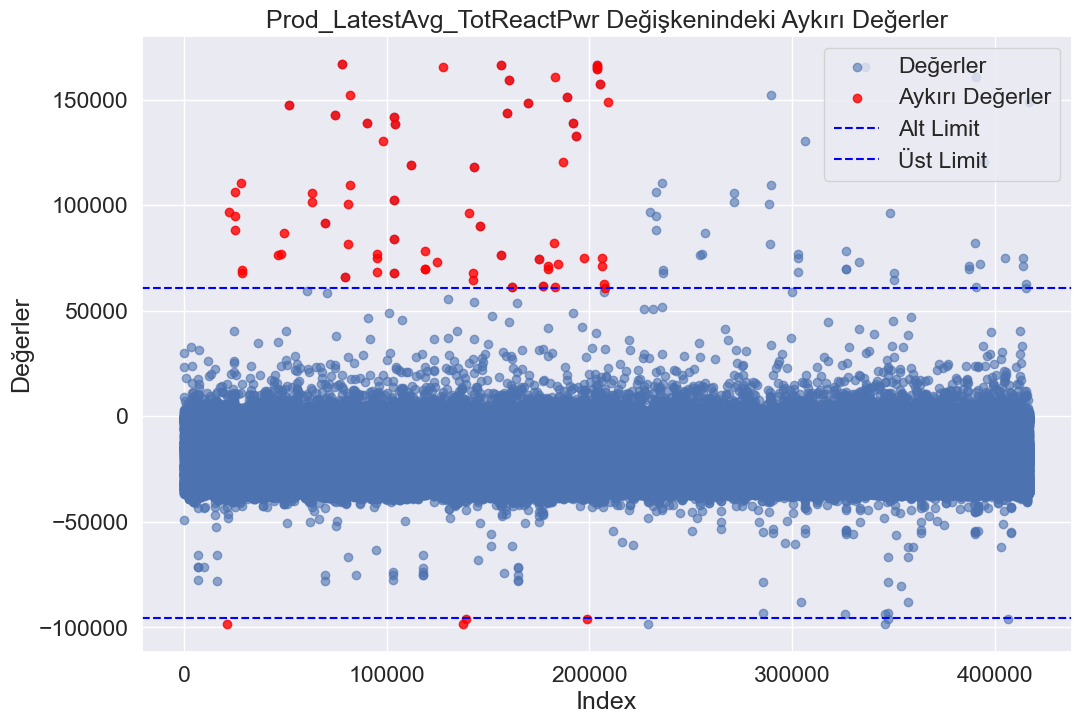

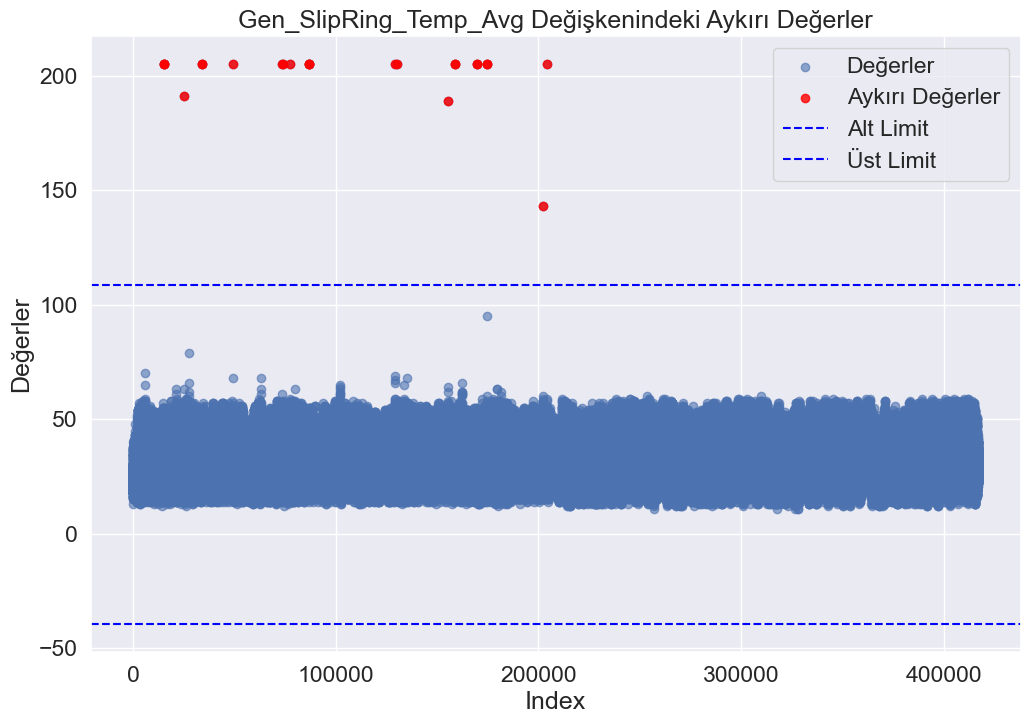

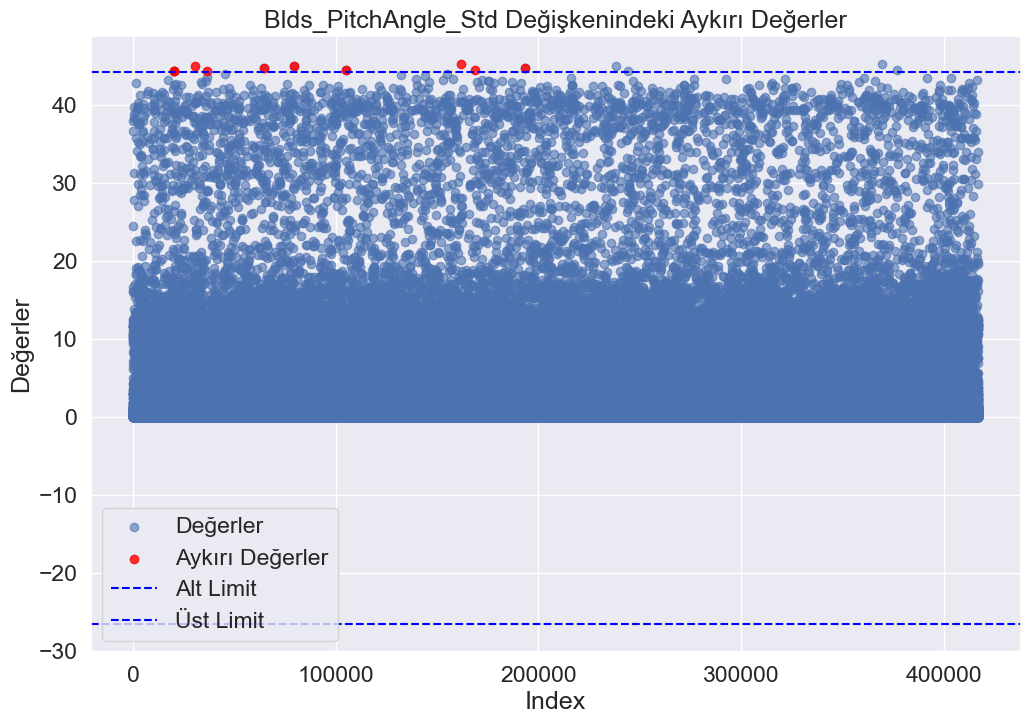

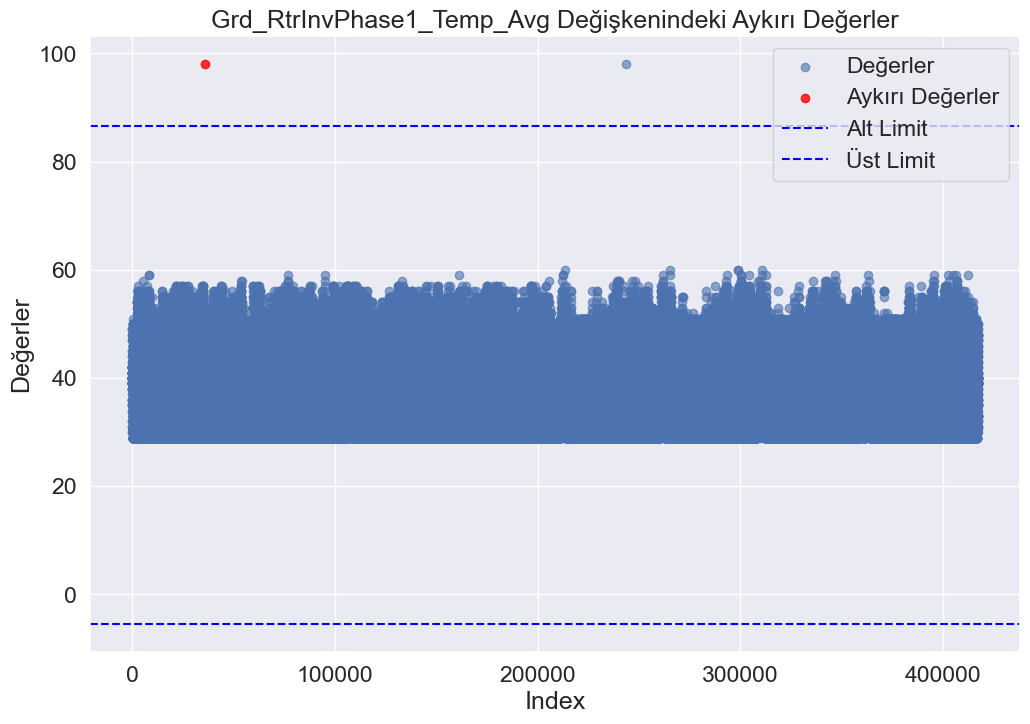

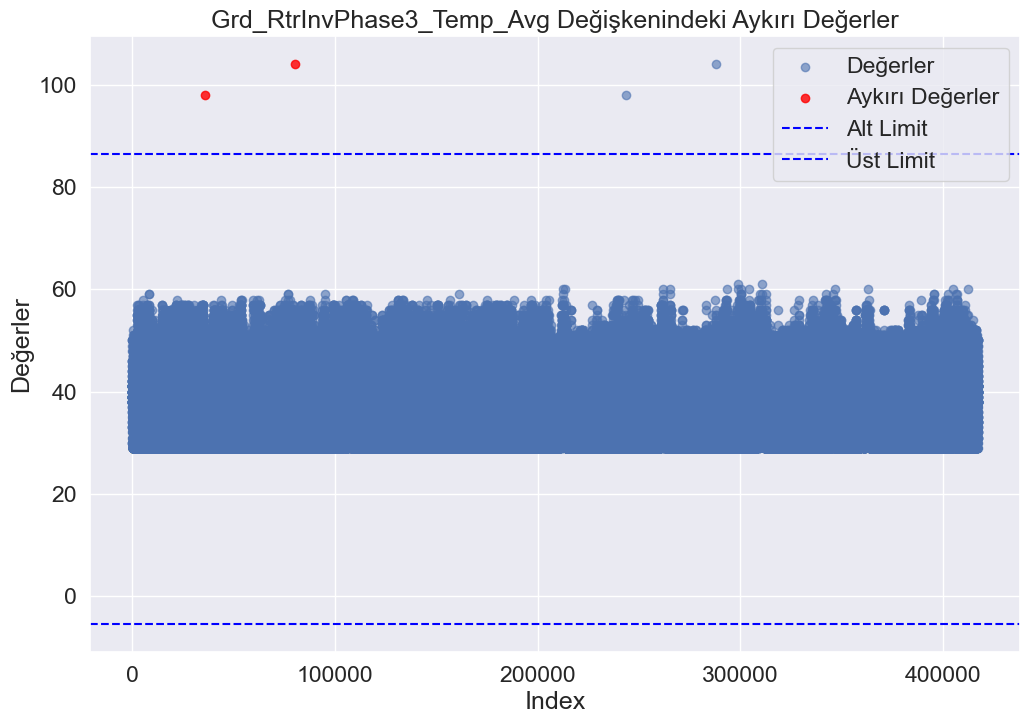

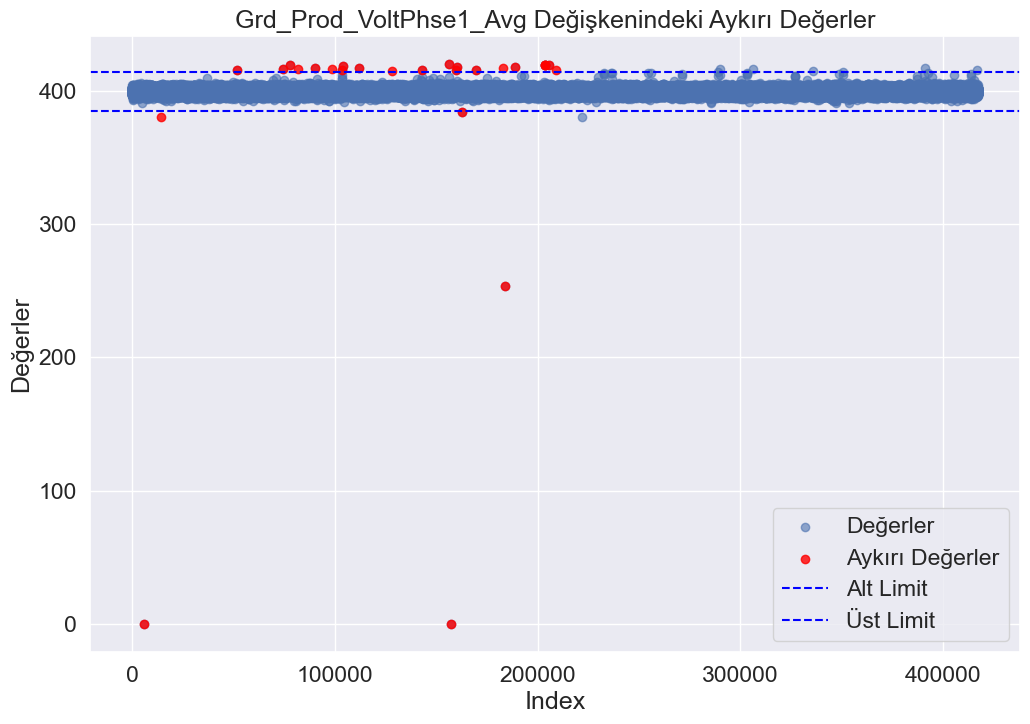

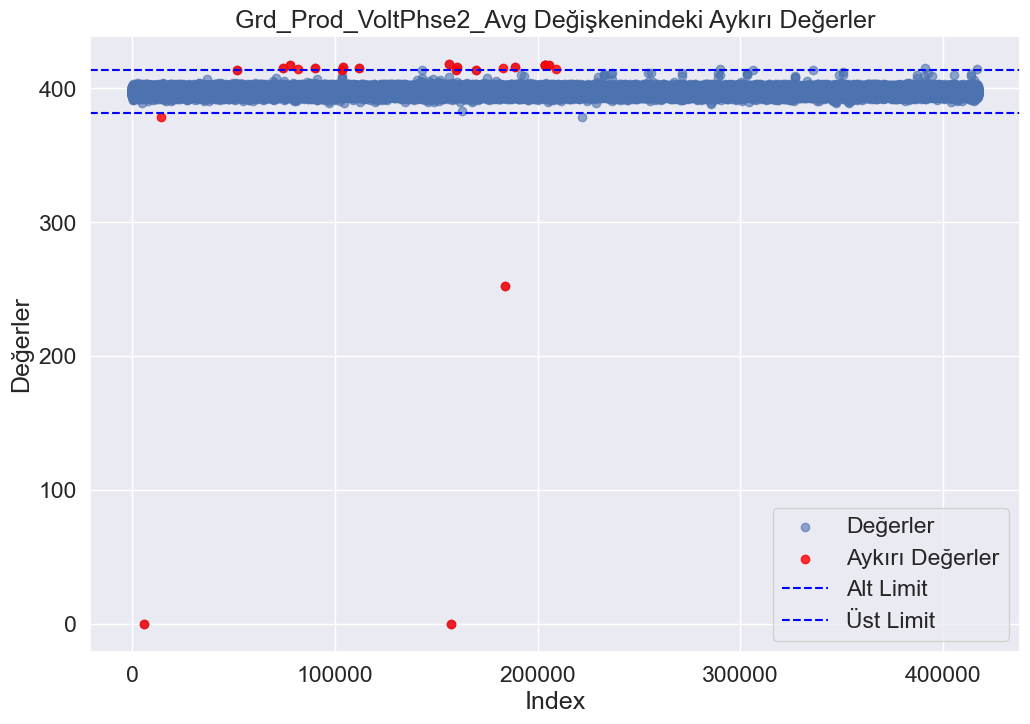

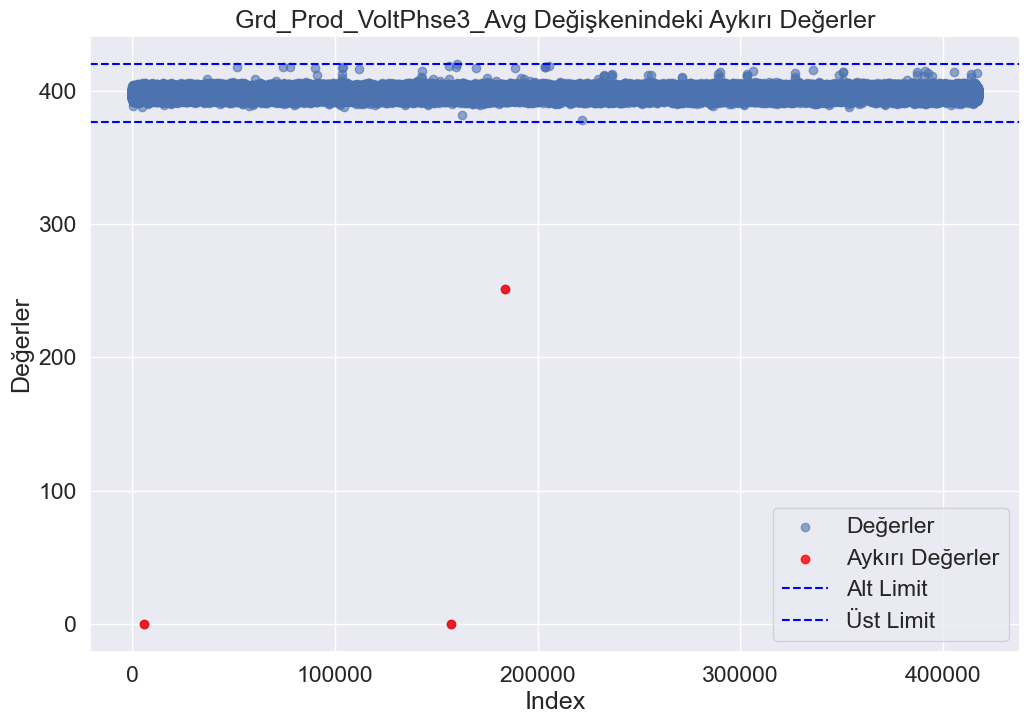

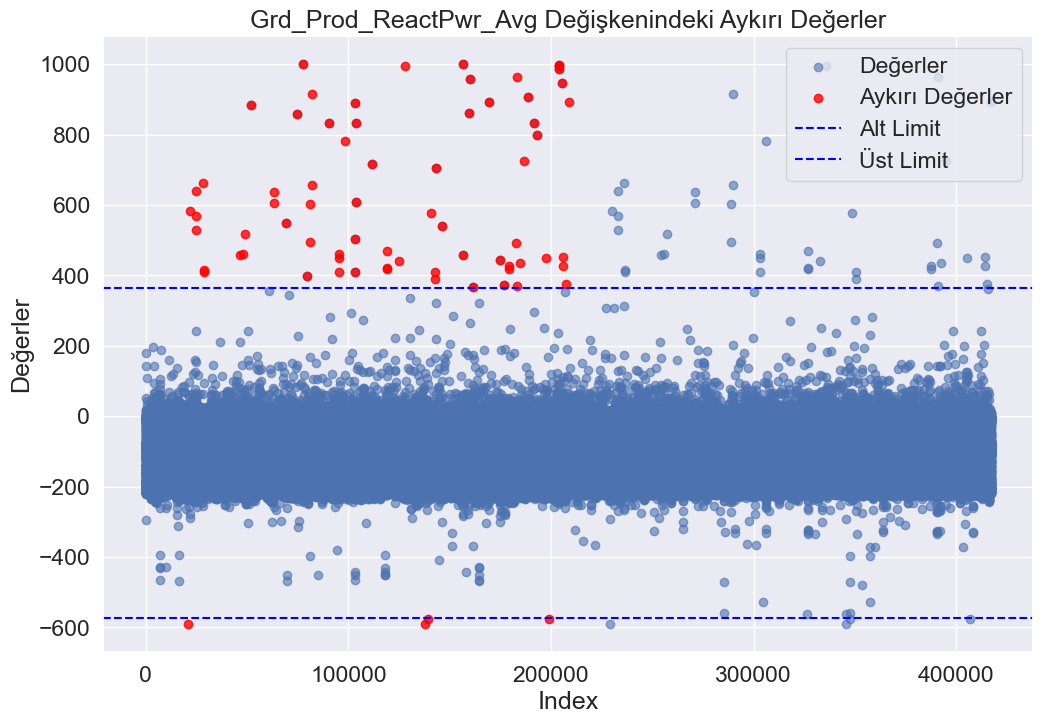

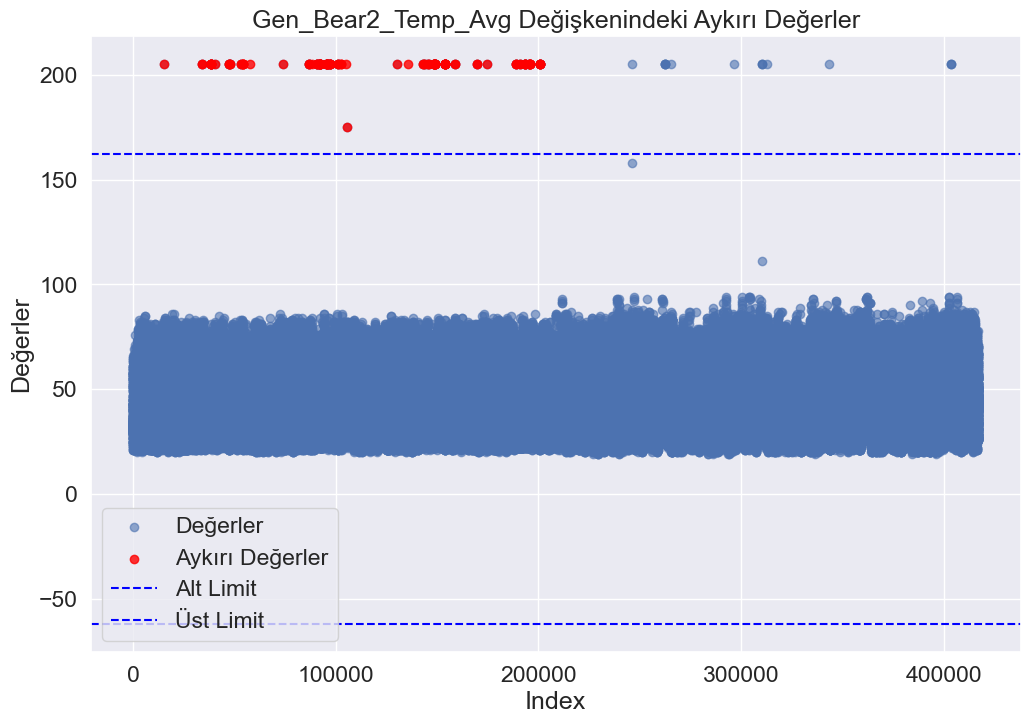

In [ ]:
#aykırı değerleri görselleştirme
for col in outlier_columns:
    low_limit, up_limit = outlier_thresholds(df, col)
    plt.figure(figsize=(12, 8))
    plt.scatter(range(len(df)), df[col], label="Değerler", alpha=0.6)
    plt.scatter(df[(df[col] > up_limit) | (df[col] < low_limit)].index,
                df[(df[col] > up_limit) | (df[col] < low_limit)][col],
                color="red", label="Aykırı Değerler", alpha=0.8)
    plt.axhline(low_limit, color="blue", linestyle="--", label="Alt Limit")
    plt.axhline(up_limit, color="blue", linestyle="--", label="Üst Limit")
    plt.title(f"{col} Değişkenindeki Aykırı Değerler")
    plt.xlabel("Index")
    plt.ylabel("Değerler")
    plt.legend()
    plt.show()

In [ ]:
#aykırı değerleri baskılama
def replace_with_thresholds(dataframe, variable): #aykırı değerleri baskılama
    low_limit, up_limit = outlier_thresholds(dataframe, variable) #alt ve üst limiti hesaplama
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit #alt limitten küçük olanların yerine alt limiti atama
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit #üst limitten büyük olanların yerine üst limiti atama

In [ ]:
for col in outlier_columns:
    replace_with_thresholds(df, col)

In [ ]:
#aykırı değerleri tekrardan kontrol
for col in num_cols:
    print(col, check_outlier(df, col))

Gen_RPM_Max False
Gen_RPM_Min False
Gen_RPM_Avg False
Gen_RPM_Std False
Gen_Bear_Temp_Avg False
Gen_Phase1_Temp_Avg False
Gen_Phase2_Temp_Avg False
Gen_Phase3_Temp_Avg False
Hyd_Oil_Temp_Avg False
Gear_Oil_Temp_Avg False
Gear_Bear_Temp_Avg False
Nac_Temp_Avg False
Rtr_RPM_Max False
Rtr_RPM_Min False
Rtr_RPM_Avg False
Amb_WindSpeed_Max False
Amb_WindSpeed_Min False
Amb_WindSpeed_Avg False
Amb_WindSpeed_Std False
Amb_WindDir_Relative_Avg False
Amb_WindDir_Abs_Avg False
Amb_Temp_Avg False
Prod_LatestAvg_ActPwrGen0 False
Prod_LatestAvg_ActPwrGen1 False
Prod_LatestAvg_TotActPwr False
Prod_LatestAvg_ReactPwrGen0 False
Prod_LatestAvg_ReactPwrGen1 False
Prod_LatestAvg_TotReactPwr False
HVTrafo_Phase1_Temp_Avg False
HVTrafo_Phase2_Temp_Avg False
HVTrafo_Phase3_Temp_Avg False
Grd_InverterPhase1_Temp_Avg False
Cont_Top_Temp_Avg False
Cont_Hub_Temp_Avg False
Cont_VCP_Temp_Avg False
Gen_SlipRing_Temp_Avg False
Spin_Temp_Avg False
Blds_PitchAngle_Min False
Blds_PitchAngle_Max False
Blds_PitchAngle_A

In [ ]:
##Veri setinde toplamda 14 değişkende 562 aykırı değer vardır.
#Bu aykırı değerleri tespit etmek için kullanılan alt ve üst limiti hesaplarken q1 değeri 0.01, q3 değeri ise 0.99 olucak şekilde alındı
#Sebebi veri setinin yapısını bozmamak için üstten bir tıraşlama gibi düşünülebilir
#modelin doğruluğunu bozmaması için aykırı değerleri alt ve ült limite baskıladım

            Turbine_ID  Ratio
Turbine_ID                   
T11             104797 25.123
T07             104738 25.109
T01             104682 25.095
T06             102920 24.673
##########################################


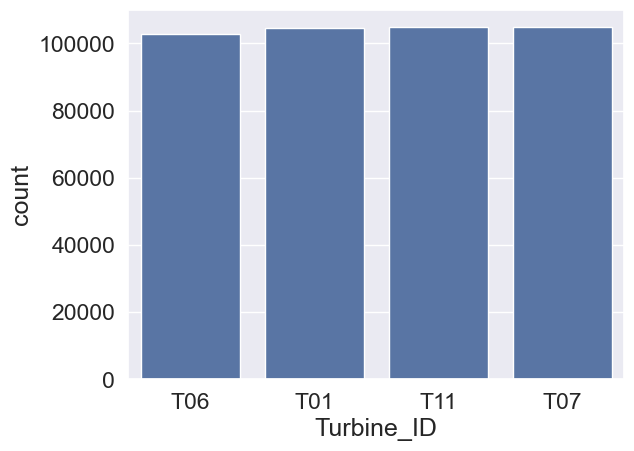

                     Grd_Prod_CosPhi_Avg  Ratio
Grd_Prod_CosPhi_Avg                            
1.000                             200973 48.179
0.900                              69769 16.726
0.700                              50389 12.080
0.800                              38839  9.311
0.600                              29393  7.046
0.500                              15442  3.702
0.400                               8913  2.137
0.300                               3245  0.778
0.200                                174  0.042
##########################################


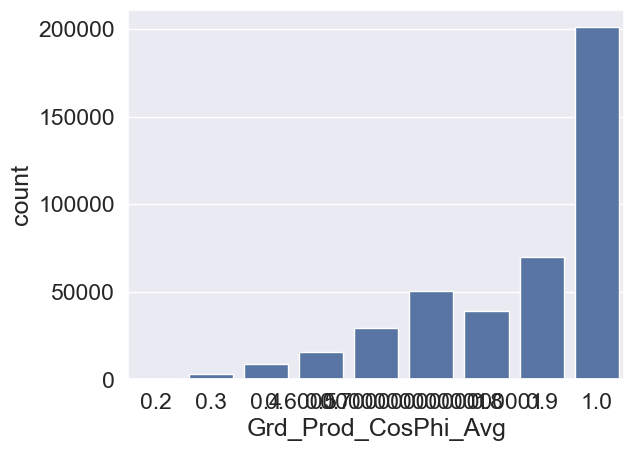

                   Grd_Prod_Freq_Avg  Ratio
Grd_Prod_Freq_Avg                          
50.000                        410448 98.396
49.900                          4376  1.049
50.100                          2310  0.554
0.000                              1  0.000
48.800                             1  0.000
49.600                             1  0.000
##########################################


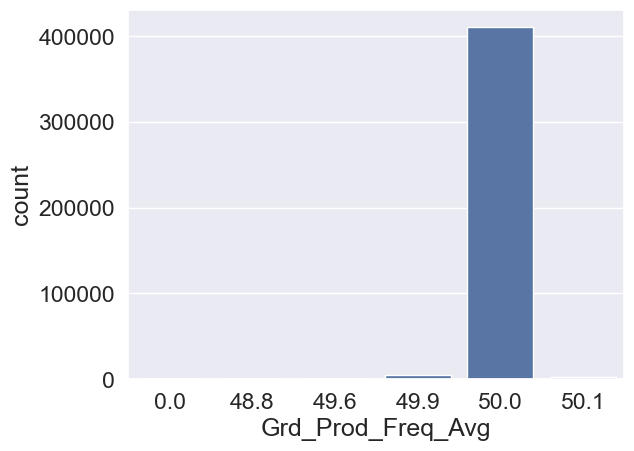

In [ ]:
####################################################################################
# 5- Keşifci Veri Analizi
####################################################################################


#kategorik değişken analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

In [ ]:
#tüm türbinlerde hedef değişkenlerle diğer değişkenlerin izlenmesi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [ ]:
for col in cat_cols:
    target_summary_with_cat(df, "Prod_LatestAvg_TotActPwr", col)

            TARGET_MEAN
Turbine_ID             
T01           86211.534
T06           89906.228
T07           91179.927
T11           90347.098


                     TARGET_MEAN
Grd_Prod_CosPhi_Avg             
0.200                   6907.431
0.300                   6697.328
0.400                   8287.261
0.500                   6156.991
0.600                   3880.146
0.700                   3658.172
0.800                  13703.654
0.900                  38369.931
1.000                 167169.365


                   TARGET_MEAN
Grd_Prod_Freq_Avg             
0.000                56339.000
48.800                   0.000
49.600               -1178.000
49.900               79565.892
50.000               89599.511
50.100               74405.680




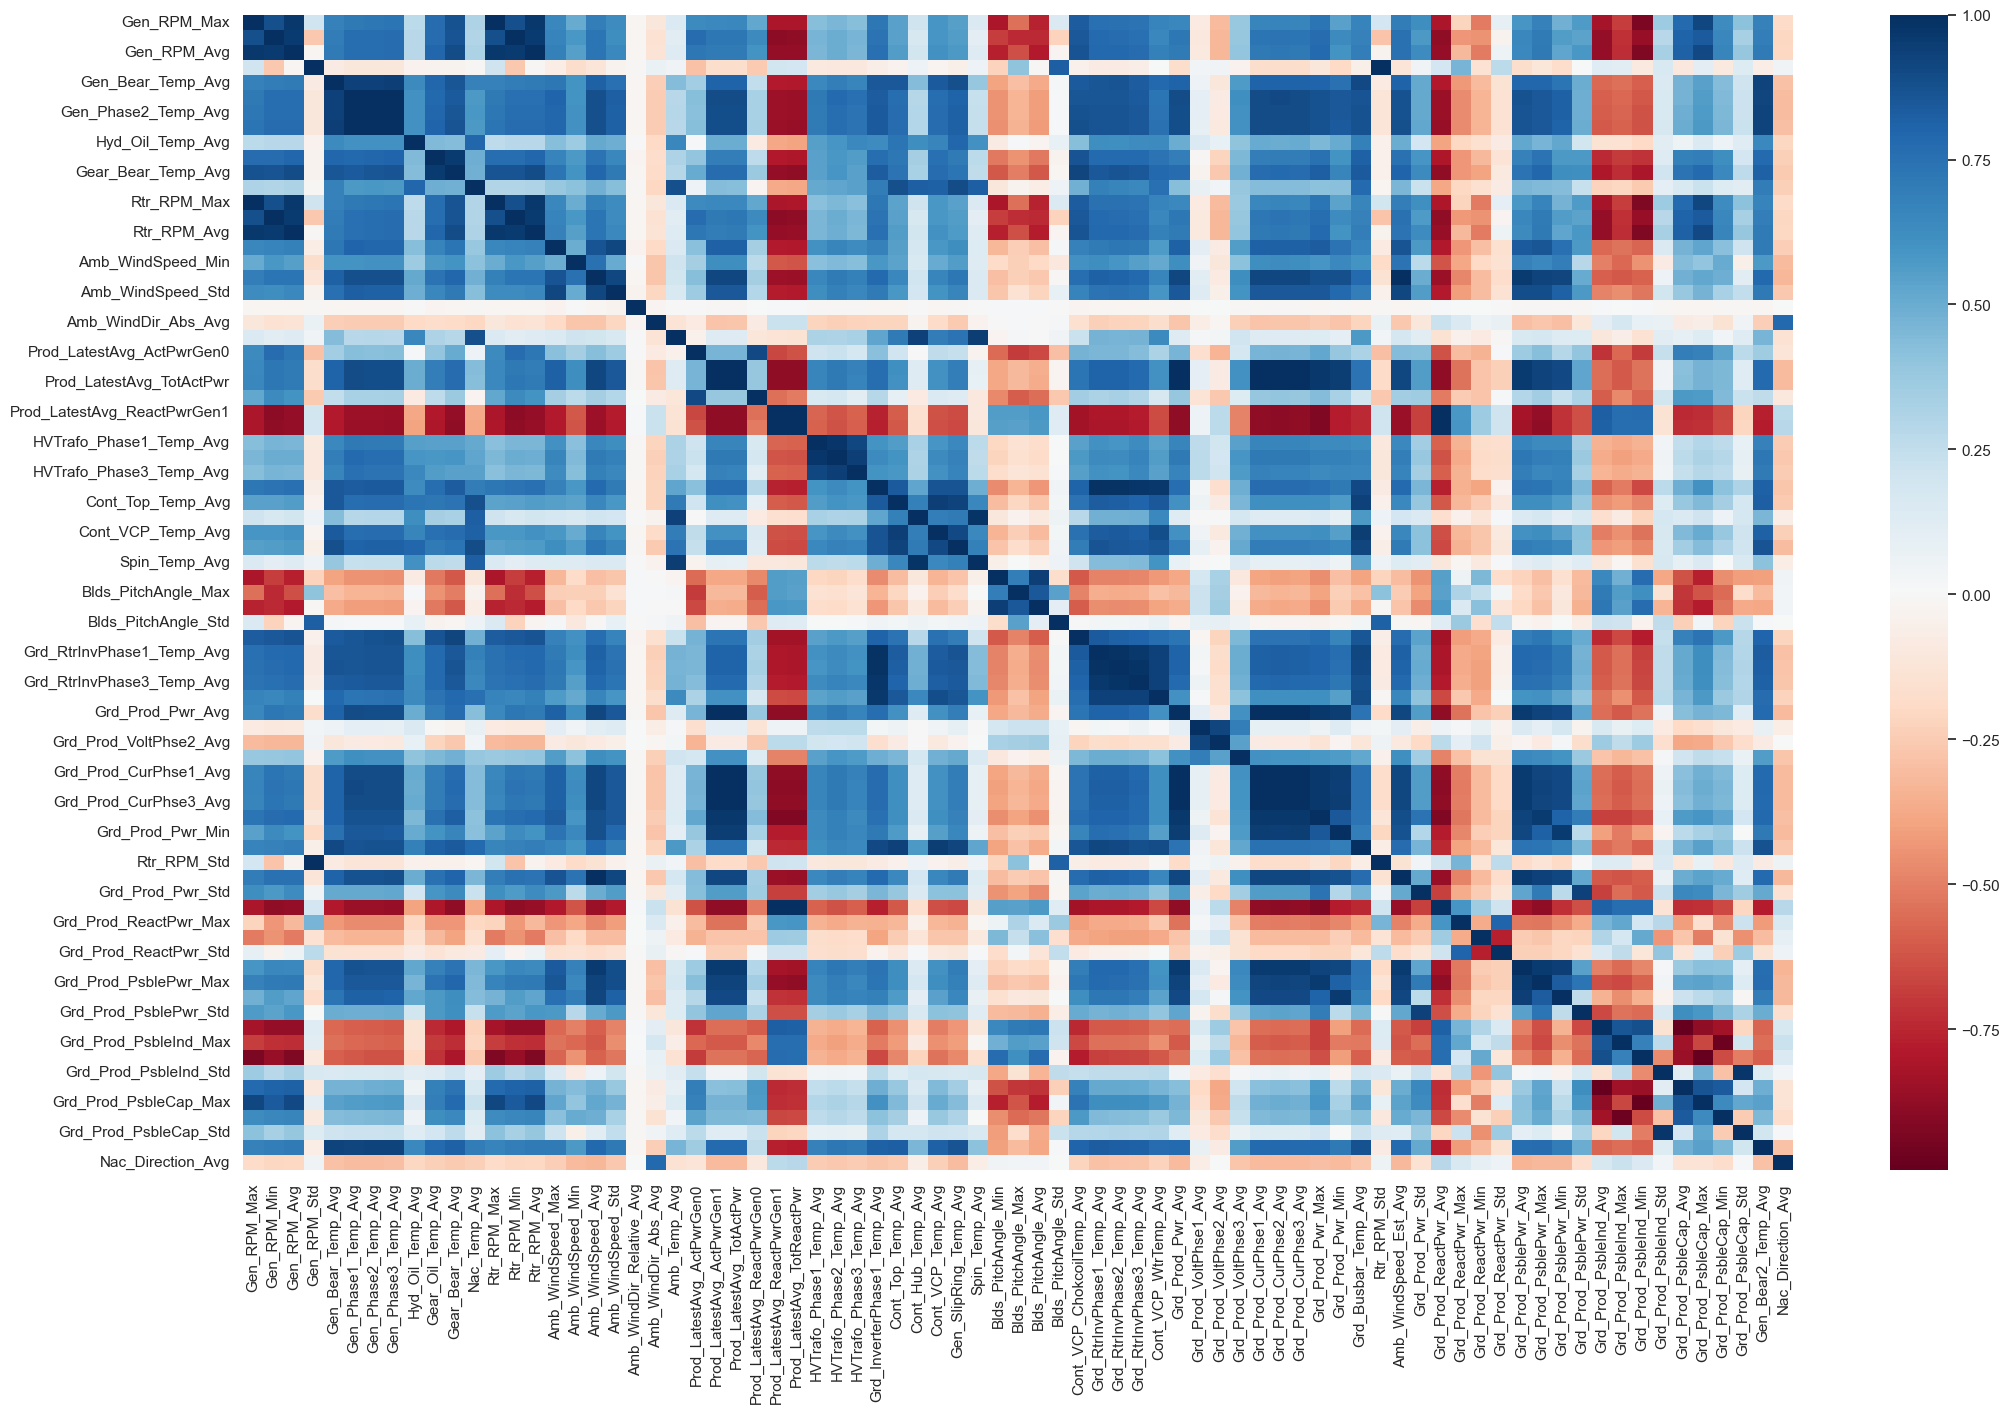

['Gen_RPM_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Gear_Bear_Temp_Avg',
 'Rtr_RPM_Max',
 'Rtr_RPM_Min',
 'Rtr_RPM_Avg',
 'Amb_WindSpeed_Std',
 'Prod_LatestAvg_ActPwrGen1',
 'Prod_LatestAvg_TotActPwr',
 'Prod_LatestAvg_ReactPwrGen0',
 'Prod_LatestAvg_TotReactPwr',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg',
 'Cont_Hub_Temp_Avg',
 'Cont_VCP_Temp_Avg',
 'Gen_SlipRing_Temp_Avg',
 'Spin_Temp_Avg',
 'Blds_PitchAngle_Avg',
 'Cont_VCP_ChokcoilTemp_Avg',
 'Grd_RtrInvPhase1_Temp_Avg',
 'Grd_RtrInvPhase2_Temp_Avg',
 'Grd_RtrInvPhase3_Temp_Avg',
 'Cont_VCP_WtrTemp_Avg',
 'Grd_Prod_Pwr_Avg',
 'Grd_Prod_VoltPhse2_Avg',
 'Grd_Prod_CurPhse1_Avg',
 'Grd_Prod_CurPhse2_Avg',
 'Grd_Prod_CurPhse3_Avg',
 'Grd_Prod_Pwr_Max',
 'Grd_Prod_Pwr_Min',
 'Grd_Busbar_Temp_Avg',
 'Rtr_RPM_Std',
 'Amb_WindSpeed_Est_Avg',
 'Grd_Prod_ReactPwr_Avg',
 'Grd_Prod_PsblePwr_Avg',
 'Grd_Prod_PsblePwr_Max',
 'Grd_Prod_PsblePwr_Min',
 'Grd_Prod_PsblePwr_Std',
 'Grd_Prod_PsbleInd_

In [ ]:
#korelasyon analizi
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (25, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list
    print(drop_list)


high_correlated_cols(df[num_cols],plot=True)

In [ ]:
correlations = df[num_cols].corr()["Prod_LatestAvg_TotActPwr"].sort_values(ascending=False)


high_corr = correlations[correlations > 0.91].index
high_corr = high_corr.drop("Prod_LatestAvg_TotActPwr")

In [ ]:
#yüksek korelasyon olan değişkenleri silme
df = df.drop(columns=high_corr)
df.shape #417137, 72

(417137, 72)

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print("#############")
print(f"Cat_Cols : {cat_cols}") #['Turbine_ID', 'Grd_Prod_CosPhi_Avg', 'Grd_Prod_Freq_Avg']
print("#############")
print(f"Num_Cols : {num_cols}") #68 tane var
print("#############")
print(f"Cat_But_Car : {cat_but_car}") #['Timestamp']

Observations: 417137
Variables: 72
cat_cols: 3
num_cols: 68
cat_but_car: 1
num_but_cat: 2
#############
Cat_Cols : ['Turbine_ID', 'Grd_Prod_CosPhi_Avg', 'Grd_Prod_Freq_Avg']
#############
Num_Cols : ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1', 'Prod_LatestAvg_TotReactPwr', 'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Spin_Temp_Avg', 'Blds_Pit

In [ ]:
#korelasyon kısmında hedef değişkenle korelasyonu 0.91 den büyük ollan değişkenler silindi
#korelasyon matrisi

df_ = df.copy()

In [ ]:
####################################################################################
#Feature Engineering
####################################################################################

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

#veriyi zamana göre sıralama
df =  df.sort_values("Timestamp")
df.head()

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Amb_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_TotReactPwr,HVTrafo_Phase1_Temp_Avg,HVTrafo_Phase2_Temp_Avg,HVTrafo_Phase3_Temp_Avg,Grd_InverterPhase1_Temp_Avg,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Gen_SlipRing_Temp_Avg,Spin_Temp_Avg,Blds_PitchAngle_Min,Blds_PitchAngle_Max,Blds_PitchAngle_Avg,Blds_PitchAngle_Std,Cont_VCP_ChokcoilTemp_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Cont_VCP_WtrTemp_Avg,Grd_Prod_CosPhi_Avg,Grd_Prod_Freq_Avg,Grd_Prod_VoltPhse1_Avg,Grd_Prod_VoltPhse2_Avg,Grd_Prod_VoltPhse3_Avg,Grd_Busbar_Temp_Avg,Rtr_RPM_Std,Amb_WindSpeed_Est_Avg,Grd_Prod_Pwr_Std,Grd_Prod_ReactPwr_Avg,Grd_Prod_ReactPwr_Max,Grd_Prod_ReactPwr_Min,Grd_Prod_ReactPwr_Std,Grd_Prod_PsblePwr_Min,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
176449,T06,2016-01-01 00:00:00+00:00,1270.000,1232.800,1248.500,6.800,42.000,51,52,53,30,43,48,29,11.200,10.900,11.100,6.000,1.600,3.800,0.600,-3.100,201.500,18,0,10465.000,0,-12621,-12621.000,45,48,45,39,38,28,38,26.000,20,-1.100,0.900,0.000,0.500,96,40.000,40,38.000,38,0.600,50.000,400.700,398.500,397.400,37,0.100,4.000,36.900,-75.500,0.100,-94.000,16.500,0.000,36.700,-307.100,0.000,-880.600,180.000,307.100,880.600,0.000,180.000,35,204.600
176521,T11,2016-01-01 00:00:00+00:00,1339.400,1233.300,1270.900,18.800,42.000,59,61,60,30,48,55,27,11.900,10.900,11.300,8.600,2.600,5.300,0.700,-7.800,199.100,18,0,41059.000,0,-13521,-13521.000,46,51,46,40,41,28,42,27.000,20,-2.100,0.900,-1.400,0.300,90,39.000,40,40.000,38,0.900,50.000,400.700,398.200,398.000,39,0.200,5.400,51.800,-81.100,-72.500,-100.100,5.000,153.600,51.700,-973.400,-752.600,-1000.000,56.500,973.400,1000.000,752.600,56.500,38,206.900
129950,T07,2016-01-01 00:00:00+00:00,1317.500,1229.500,1254.900,13.800,41.000,62,62,61,32,45,49,27,11.700,10.900,11.100,14.400,0.900,4.100,1.100,-18.600,178.700,18,0,18831.000,0,-11991,-11991.000,71,75,75,39,38,28,39,26.000,20,-2.000,2.500,-0.300,0.800,91,39.000,39,41.000,38,0.800,50.000,402.200,399.900,398.700,36,0.100,4.400,75.200,-71.700,0.200,-95.000,24.700,0.000,74.900,-536.500,0.000,-1000.000,338.900,536.500,1000.000,0.000,338.900,39,197.300
167481,T01,2016-01-01 00:00:00+00:00,1277.400,1226.100,1249.000,9.000,41.000,58,59,58,30,44,48,28,11.300,10.900,11.100,11.600,0.500,3.300,0.900,-12.400,206.100,18,-107,4313.000,-99,-5636,-5735.000,68,76,65,39,39,28,43,25.000,20,-1.100,4.500,0.600,0.900,91,39.000,39,38.000,39,0.700,50.000,401.600,399.900,399.200,38,0.100,3.600,35.300,-34.900,13.200,-100.000,36.200,0.000,31.900,-144.400,0.000,-584.500,157.100,144.400,584.500,0.000,157.100,37,218.500
1884,T01,2016-01-01 00:10:00+00:00,1268.300,93.300,999.700,435.900,41.000,58,59,59,30,44,48,28,11.200,0.000,8.800,12.500,0.400,3.200,0.900,-1.100,217.400,18,-753,1735.000,-867,-3871,-4738.000,68,76,65,38,39,28,42,25.000,20,-0.900,59.600,8.100,14.700,91,37.000,36,37.000,37,0.700,50.000,401.900,400.700,399.500,38,4.000,3.300,30.200,-28.000,1.800,-100.100,34.600,0.000,24.700,-79.600,0.000,-501.000,123.700,79.600,501.000,0.000,123.700,37,218.500


In [ ]:
df['year'] = df['Timestamp'].dt.year #yıl
df['month'] = df['Timestamp'].dt.month #ay
df['day'] = df['Timestamp'].dt.day # gün
df['dayofweek'] = df['Timestamp'].dt.dayofweek#haftanın günü
df['hour'] = df['Timestamp'].dt.hour #saat
df['weekofyear'] = df['Timestamp'].dt.isocalendar().week # yılın haftası

c_cols =["year", "month", "day", "dayofweek", "hour", "weekofyear"]

cat_cols.extend(c_cols)

In [ ]:
########################
# Lag/Shifted Features
########################


def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))


def lag_features(dataframe, feature, lags, group_cols):
    if not group_cols:
        raise ValueError("Gruplama sütunları (group_cols) belirtilmelidir.")

    for lag in lags:
        dataframe[f'{feature}_lag_{lag}'] = (
                dataframe.groupby(group_cols)[feature].transform(lambda x: x.shift(lag)) + random_noise(dataframe))
    return dataframe

In [ ]:
df = lag_features(df,"Prod_LatestAvg_TotActPwr", lags=[30,37,44,53,60,67,74,81,162,324,648], group_cols="Turbine_ID")
df.head()

#eksik değerleri temizleme
df = df.dropna()
df.isnull().sum().sum()

0

In [ ]:
# dönemsellikleri yakalamak için sinüs ve kosinüs dönüşümleri kulanma
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


# sinüs ve kosinüs dönüşümü
df["Amb_WindDir_Abs_Sin"] = np.sin(np.radians(df["Amb_WindDir_Abs_Avg"]))
df["Amb_WindDir_Abs_Cos"] = np.cos(np.radians(df["Amb_WindDir_Abs_Avg"]))

df.shape #(414545, 95)


df.to_csv("wind_turbines_2016_2017_temiz.csv", index=False)

In [ ]:
#Encoding
df.shape

cat_cols.remove('Turbine_ID')
cat_cols

df = pd.get_dummies(df,columns=cat_cols,drop_first=True)
df.head()
df.shape
df.info

for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [ ]:
data = df.copy()

In [ ]:
df.head()

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Amb_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_TotReactPwr,HVTrafo_Phase1_Temp_Avg,HVTrafo_Phase2_Temp_Avg,HVTrafo_Phase3_Temp_Avg,Grd_InverterPhase1_Temp_Avg,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Gen_SlipRing_Temp_Avg,Spin_Temp_Avg,Blds_PitchAngle_Min,Blds_PitchAngle_Max,Blds_PitchAngle_Avg,Blds_PitchAngle_Std,Cont_VCP_ChokcoilTemp_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Cont_VCP_WtrTemp_Avg,Grd_Prod_VoltPhse1_Avg,Grd_Prod_VoltPhse2_Avg,Grd_Prod_VoltPhse3_Avg,Grd_Busbar_Temp_Avg,Rtr_RPM_Std,Amb_WindSpeed_Est_Avg,Grd_Prod_Pwr_Std,Grd_Prod_ReactPwr_Avg,Grd_Prod_ReactPwr_Max,Grd_Prod_ReactPwr_Min,Grd_Prod_ReactPwr_Std,Grd_Prod_PsblePwr_Min,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg,Prod_LatestAvg_TotActPwr_lag_30,Prod_LatestAvg_TotActPwr_lag_37,Prod_LatestAvg_TotActPwr_lag_44,Prod_LatestAvg_TotActPwr_lag_53,Prod_LatestAvg_TotActPwr_lag_60,Prod_LatestAvg_TotActPwr_lag_67,Prod_LatestAvg_TotActPwr_lag_74,Prod_LatestAvg_TotActPwr_lag_81,Prod_LatestAvg_TotActPwr_lag_162,Prod_LatestAvg_TotActPwr_lag_324,Prod_LatestAvg_TotActPwr_lag_648,hour_sin,hour_cos,month_sin,month_cos,Amb_WindDir_Abs_Sin,Amb_WindDir_Abs_Cos,Grd_Prod_CosPhi_Avg_0.3,Grd_Prod_CosPhi_Avg_0.4,Grd_Prod_CosPhi_Avg_0.5,Grd_Prod_CosPhi_Avg_0.6000000000000001,Grd_Prod_CosPhi_Avg_0.7000000000000001,Grd_Prod_CosPhi_Avg_0.8,Grd_Prod_CosPhi_Avg_0.9,Grd_Prod_CosPhi_Avg_1.0,Grd_Prod_Freq_Avg_48.8,Grd_Prod_Freq_Avg_49.6,Grd_Prod_Freq_Avg_49.9,Grd_Prod_Freq_Avg_50.0,Grd_Prod_Freq_Avg_50.1,year_2017,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,weekofyear_7,weekofyear_8,weekofyear_9,weekofyear_10,weekofyear_11,weekofyear_12,weekofyear_13,weekofyear_14,weekofyear_15,weekofyear_16,weekofyear_17,weekofyear_18,weekofyear_19,weekofyear_20,weekofyear_21,weekofyear_22,weekofyear_23,weekofyear_24,weekofyear_25,weekofyear_26,weekofyear_27,weekofyear_28,weekofyear_29,weekofyear_30,weekofyear_31,weekofyear_32,weekofyear_33,weekofyear_34,weekofyear_35,weekofyear_36,weekofyear_37,weekofyear_38,weekofyear_39,weekofyear_40,weekofyear_41,weekofyear_42,weekofyear_43,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52
117604,T06,2016-01-05 12:00:00+00:00,1688.500,1345.500,1589.300,67.100,47.000,64,65,65,31,55,59,26,14.900,11.900,14.100,14.500,2.100,8.100,1.600,-17.700,307.400,15,0,164178.000,0,-30258,-30258.000,63,68,65,35,38,24,39,26.000,17,-2.400,-0.500,-2.100,0.300,104,37.000,37,35.000,33,399.100,397.400,398.200,40,0.600,8.300,279.300,-181.600,-165.800,-199.000,8.800,474.500,279.600,-1000.000,-1000.000,-1000.000,0.000,990.100,1000.000,677.200,39.700,35,325.200,244635.424,121779.456,320646.965,330267.351,321477.526,318119.844,279401.274,153572.564,267170.941,-701.468,10462.208,0.000,-

In [ ]:
df_t01 = df[df["Turbine_ID"] == "T01"]
df_t06 = df[df["Turbine_ID"] == "T06"]
df_t07 = df[df["Turbine_ID"] == "T07"]
df_t11 = df[df["Turbine_ID"] == "T11"]

In [ ]:
####################################################################################
#Light GBM ile zaman serisi
####################################################################################


def roll_mean_features(dataframe, windows, group_cols, target_col):
    for window in windows:
        col_name = f'{target_col}_roll_mean_{window}'
        dataframe[col_name] = dataframe.groupby(group_cols)[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10).mean()
        )
    return dataframe

df = roll_mean_features(df, windows=[24, 168, 720], group_cols=['Turbine_ID'], target_col='Prod_LatestAvg_TotActPwr')

In [ ]:
df.head()
df= df.dropna()

In [ ]:
df =  df.sort_values("Timestamp")
df.tail()
df.head()
df.shape

(414505, 225)

In [ ]:
#T01 

df_t01 = df_t01.sort_values("Timestamp")
df_t01.head()


train = df_t01.loc[(df_t01["Timestamp"] < "2017-10-01"), :]

# 2017'nin son 2'ayı test seti
test = df_t01.loc[(df_t01["Timestamp"] >= "2017-10-01") & (df_t01["Timestamp"] < "2017-12-31"), :]

In [ ]:
X_train = train.drop(columns=["Timestamp","Turbine_ID", "Prod_LatestAvg_TotActPwr"])
y_train = train["Prod_LatestAvg_TotActPwr"]
X_test = test.drop(columns=["Timestamp", "Turbine_ID","Prod_LatestAvg_TotActPwr"])
y_test = test["Prod_LatestAvg_TotActPwr"]

import lightgbm as lgb

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (90816, 219)
y_train shape: (90816,)
X_test shape: (13074, 219)
y_test shape: (13074,)


In [ ]:
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=50, verbose=10)

# Tahmin ve Değerlendirme
y_pred = lgb_model.predict(X_test)

[10]	valid_0's rmse: 92164.9	valid_0's l2: 8.49437e+09
[20]	valid_0's rmse: 83359	valid_0's l2: 6.94872e+09
[30]	valid_0's rmse: 75395.8	valid_0's l2: 5.68452e+09
[40]	valid_0's rmse: 68198.2	valid_0's l2: 4.65099e+09
[50]	valid_0's rmse: 61689.2	valid_0's l2: 3.80556e+09
[60]	valid_0's rmse: 55801	valid_0's l2: 3.11376e+09
[70]	valid_0's rmse: 50478.2	valid_0's l2: 2.54805e+09
[80]	valid_0's rmse: 45664.6	valid_0's l2: 2.08526e+09
[90]	valid_0's rmse: 41314.3	valid_0's l2: 1.70687e+09
[100]	valid_0's rmse: 37383.8	valid_0's l2: 1.39755e+09
[110]	valid_0's rmse: 33829.3	valid_0's l2: 1.14442e+09
[120]	valid_0's rmse: 30616.6	valid_0's l2: 9.37375e+08
[130]	valid_0's rmse: 27712.3	valid_0's l2: 7.67973e+08
[140]	valid_0's rmse: 25084.7	valid_0's l2: 6.29242e+08
[150]	valid_0's rmse: 22710.5	valid_0's l2: 5.15767e+08
[160]	valid_0's rmse: 20561.7	valid_0's l2: 4.22783e+08
[170]	valid_0's rmse: 18620.1	valid_0's l2: 3.46706e+08
[180]	valid_0's rmse: 16867	valid_0's l2: 2.84494e+08
[190]	v

In [ ]:
y_pred = lgb_model.predict(X_test)

In [ ]:
# Performans Metrikleri
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

#MAE: 1018.0077441769271
#RMSE: 1964.4267276136961

MAE: 1018.0077441769271
RMSE: 1964.4267276136961


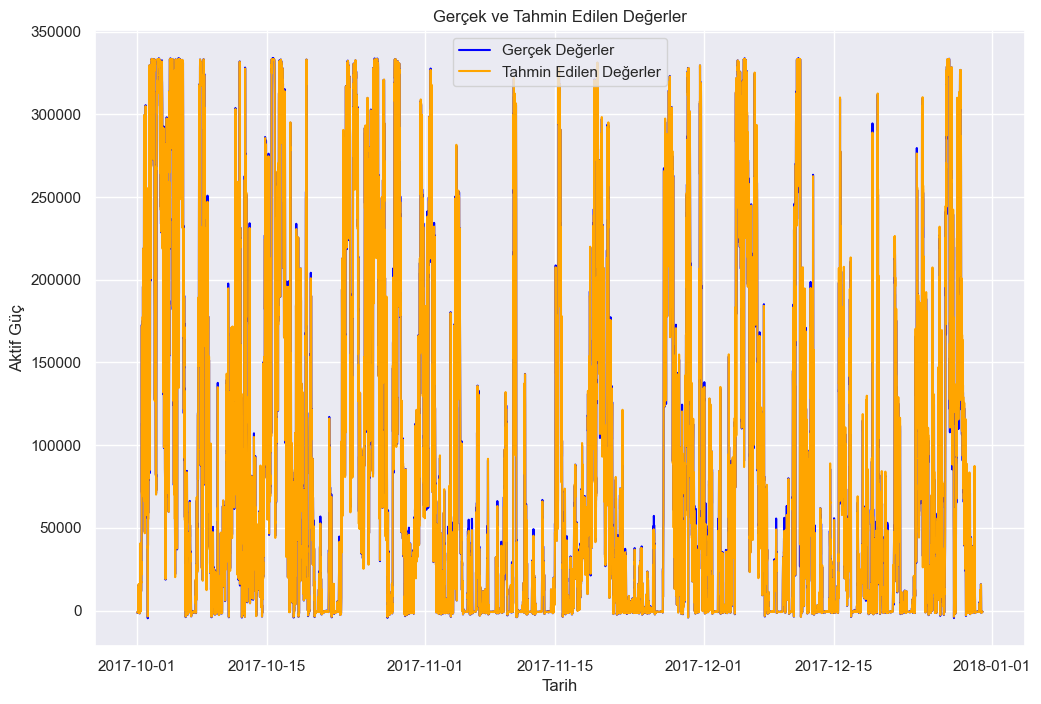

In [ ]:
#Görselleştirme
plt.figure(figsize=(12, 8))
plt.plot(test["Timestamp"], y_test, label="Gerçek Değerler", color="blue")
plt.plot(test["Timestamp"], y_pred, label="Tahmin Edilen Değerler", color="orange")
plt.legend()
plt.xlabel("Tarih")
plt.ylabel("Aktif Güç")
plt.title("Gerçek ve Tahmin Edilen Değerler")
plt.show()

In [ ]:
####################################################################################
#Prophet ile zaman serisi
####################################################################################
from prophet import Prophet

# Her bir Turbine_ID için veri setini ayırma
df_t01 = df[df["Turbine_ID"] == "T01"]
df_t06 = df[df["Turbine_ID"] == "T06"]
df_t07 = df[df["Turbine_ID"] == "T07"]
df_t11 = df[df["Turbine_ID"] == "T11"]

In [ ]:
df_p = pd.DataFrame()

In [ ]:
df_p["ds"] = df_t01["Timestamp"]
df_p["y"] = df_t01["Prod_LatestAvg_TotActPwr"]

df_p['ds'] = df_p['ds'].dt.tz_localize(None)
df_p = df_p[['ds', 'y']]
df_p.head()

df_p = df_p.reset_index(drop=True)

df_p = df_p.sort_values('ds')

In [ ]:
model = Prophet()
model.fit(df_p)

21:59:00 - cmdstanpy - INFO - Chain [1] start processing
21:59:14 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#gelecek zaman dilimleri için tahmin yapma
future = model.make_future_dataframe(freq='M',periods=2)
forecast = model.predict(future)

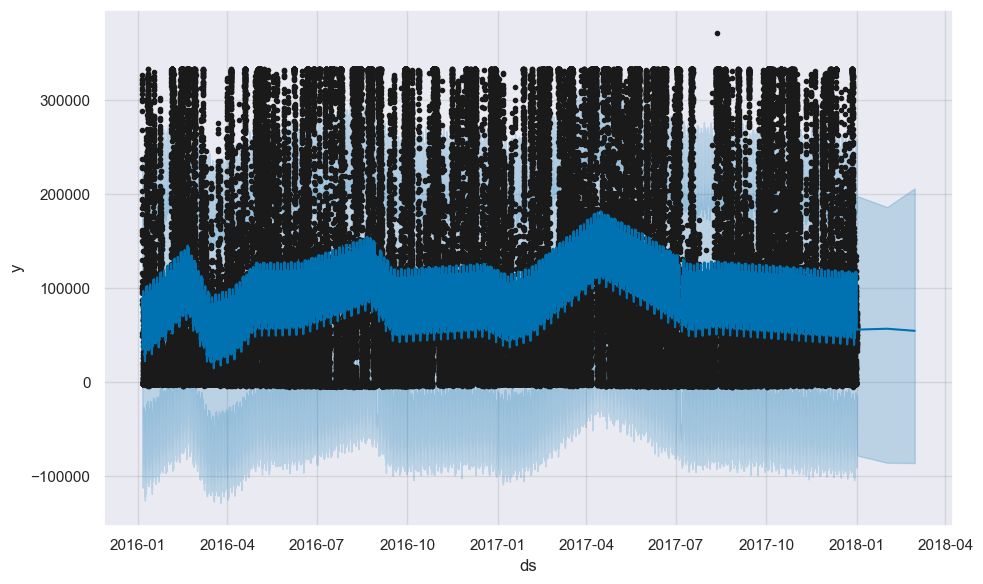

In [ ]:
#grafik oluşturma
model.plot(forecast)
plt.show()

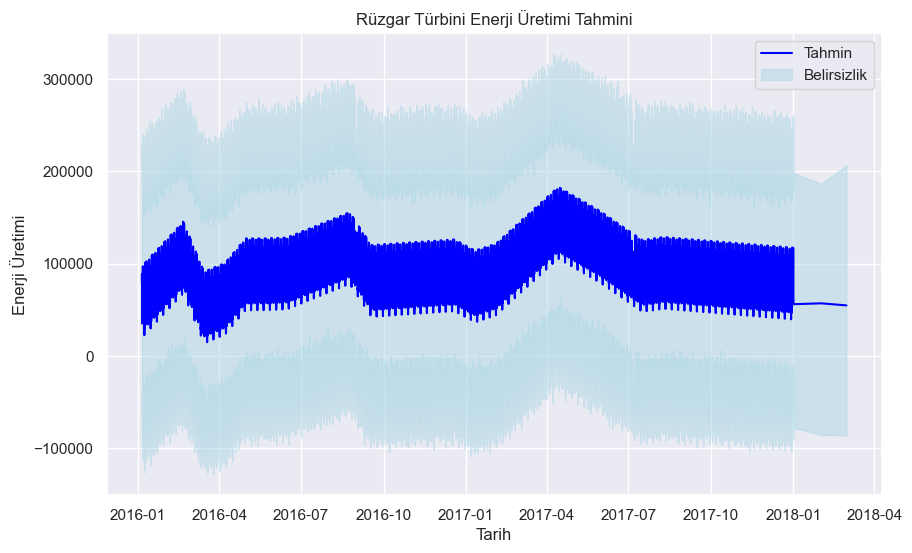

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(forecast['ds'], forecast['yhat'], label='Tahmin', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.5, label='Belirsizlik')
plt.xlabel('Tarih')
plt.ylabel('Enerji Üretimi')
plt.title('Rüzgar Türbini Enerji Üretimi Tahmini')
plt.legend()
plt.show()